In [23]:
# Useful starting lines
import numpy as np
from dataloader import *
from finance import *
from plots import *
from finance import stock, compare
from quotebankexploration import *
from wikipedia import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***
## Quotebank Data Exploration

In [ ]:
quotes = load_quotes(2020, 'unprocessed quotes')
quotebank_exploration(quotes)

The dataset comprises the following columns : 
 * `quoteID`: Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}").
 * `quotation`: Text of the longest encountered original form of the quotation.
 * `speaker`: Selected most likely speaker. This matches the first speaker entry in `probas`. If none of the speakers is selected, the speaker is defined as "None".
 * `qids`: Wikidata IDs of all aliases that match the selected speaker. If no Wikidata IDs is found, the value is '[]'.
 * `date`: Earliest occurrence date of any version of the quotation.
 * `numOccurrences`: Number of time this quotation occurs in the articles.
 * `probas`: Array representing the probabilities of each speaker having uttered the quotation.
 * `urls`: List of links to the original articles containing the quotation. 
 * `phase`: Corresponding phase of the data in which the quotation first occurred (A-E).

***
## Quotebank Data Pre-processing
We filter and transform the data according to our needs. The first step is to filter out any quotes that are not related to the company, the products or its direction board. To do so, we use a combination of white-listed words (Apple, iPhone, iPad, Macbook etc.), black-listed words that are not related to the Apple company (Big Apple, apple pie, big mac etc.) and relevant speakers (Tim Cook, Steve Jobs etc.). The filtered dataset is then saved as a pickle file.

In [ ]:
# Key-words for filtering

# One word key-words
keywords_1_word = ["iphone", "ipad", "imac", "ipod", "macbook", "mac", "airpods",
        "lightening", "magsafe", "aapl", "iwatch", "itunes", "homepod", "macos", "ios", "ipados",
        "watchos", "tvos", "wwdc", "siri", "facetime", "appstore", "icloud", "iphones"]

# Two words key-words
keywords_2_words = ["apple watch", "steve jobs", "tim cook", "face id",
        "pro display xdr", "katherine adams", "eddy cue", "craig federighi"]

# Keep only the 'Apple' that corresponds to the company
keywords_capital = ["Apple"]

# Remove all the words that can be confused with the words we are looking for
black_list = ["Big Apple"]

# Create a dictionnary of key-words
keywords = {"One word": keywords_1_word, "Two words": keywords_2_words, "Capital words": keywords_capital, "Black list": black_list}

# Speakers we want to look for quotes
speakers = ["steve jobs", "tim cook", "katherine adams", "eddy cue", "craig federighi", "john giannandrea", "greg joswiak",
    "sabih khan", "luca maestri", "deirdre o'brien", "johny srouji", "john ternus", "jeff williams", "lisa jakson",
    "stella low", "isabel ge mahe", "tor myhren", "adrian perica", "phil schiller", "arthur levinson", "james bell",
    "albert gore", "andrea jung", "monica lozano", "ronald sugar", "susan wagner"]

In [ ]:
# The idea of this section is to now apply the filter with the key-words
# we define before.

# Initialize the lists for the final plots
frequency_all = []
frequency_apple = []
years = np.arange(2008, 2009)

# Loop over all the years from 2008 to 2020
for year in years:
    # Filtering the quotes
    filt_quotes = filter_quotes(f"data/quotes-{str(year)}.json.bz2", \
        speakers = speakers, keywords = keywords, save = f"filtered_quotes_{str(year)}")
    
    # Update the list for the final plots
    frequency_all.append(filt_quotes['total'])
    frequency_apple.append(len(filt_quotes['dataframe']))
    

#### Distribution of the unprocessed and processed quotes among the years

Now we have filtered all the quotes we wants to keep for our following study, we want to know the distribution of the quotes among the years and how many quotes we deal with. The idea is also to see if there is a particular year where we have significantly more or less quotes than the others. Then, in the following figure we have plotted the total number of quotes and the number of quotes we have after filtering for every year from `2008` to `2020`.

Now, when we look the graph we have that `[... interpretation ...]` --> J'attends que Baptiste update tous les keywords qu'il y a à mettre en blacklist pour avoir les bon chiffres...

0

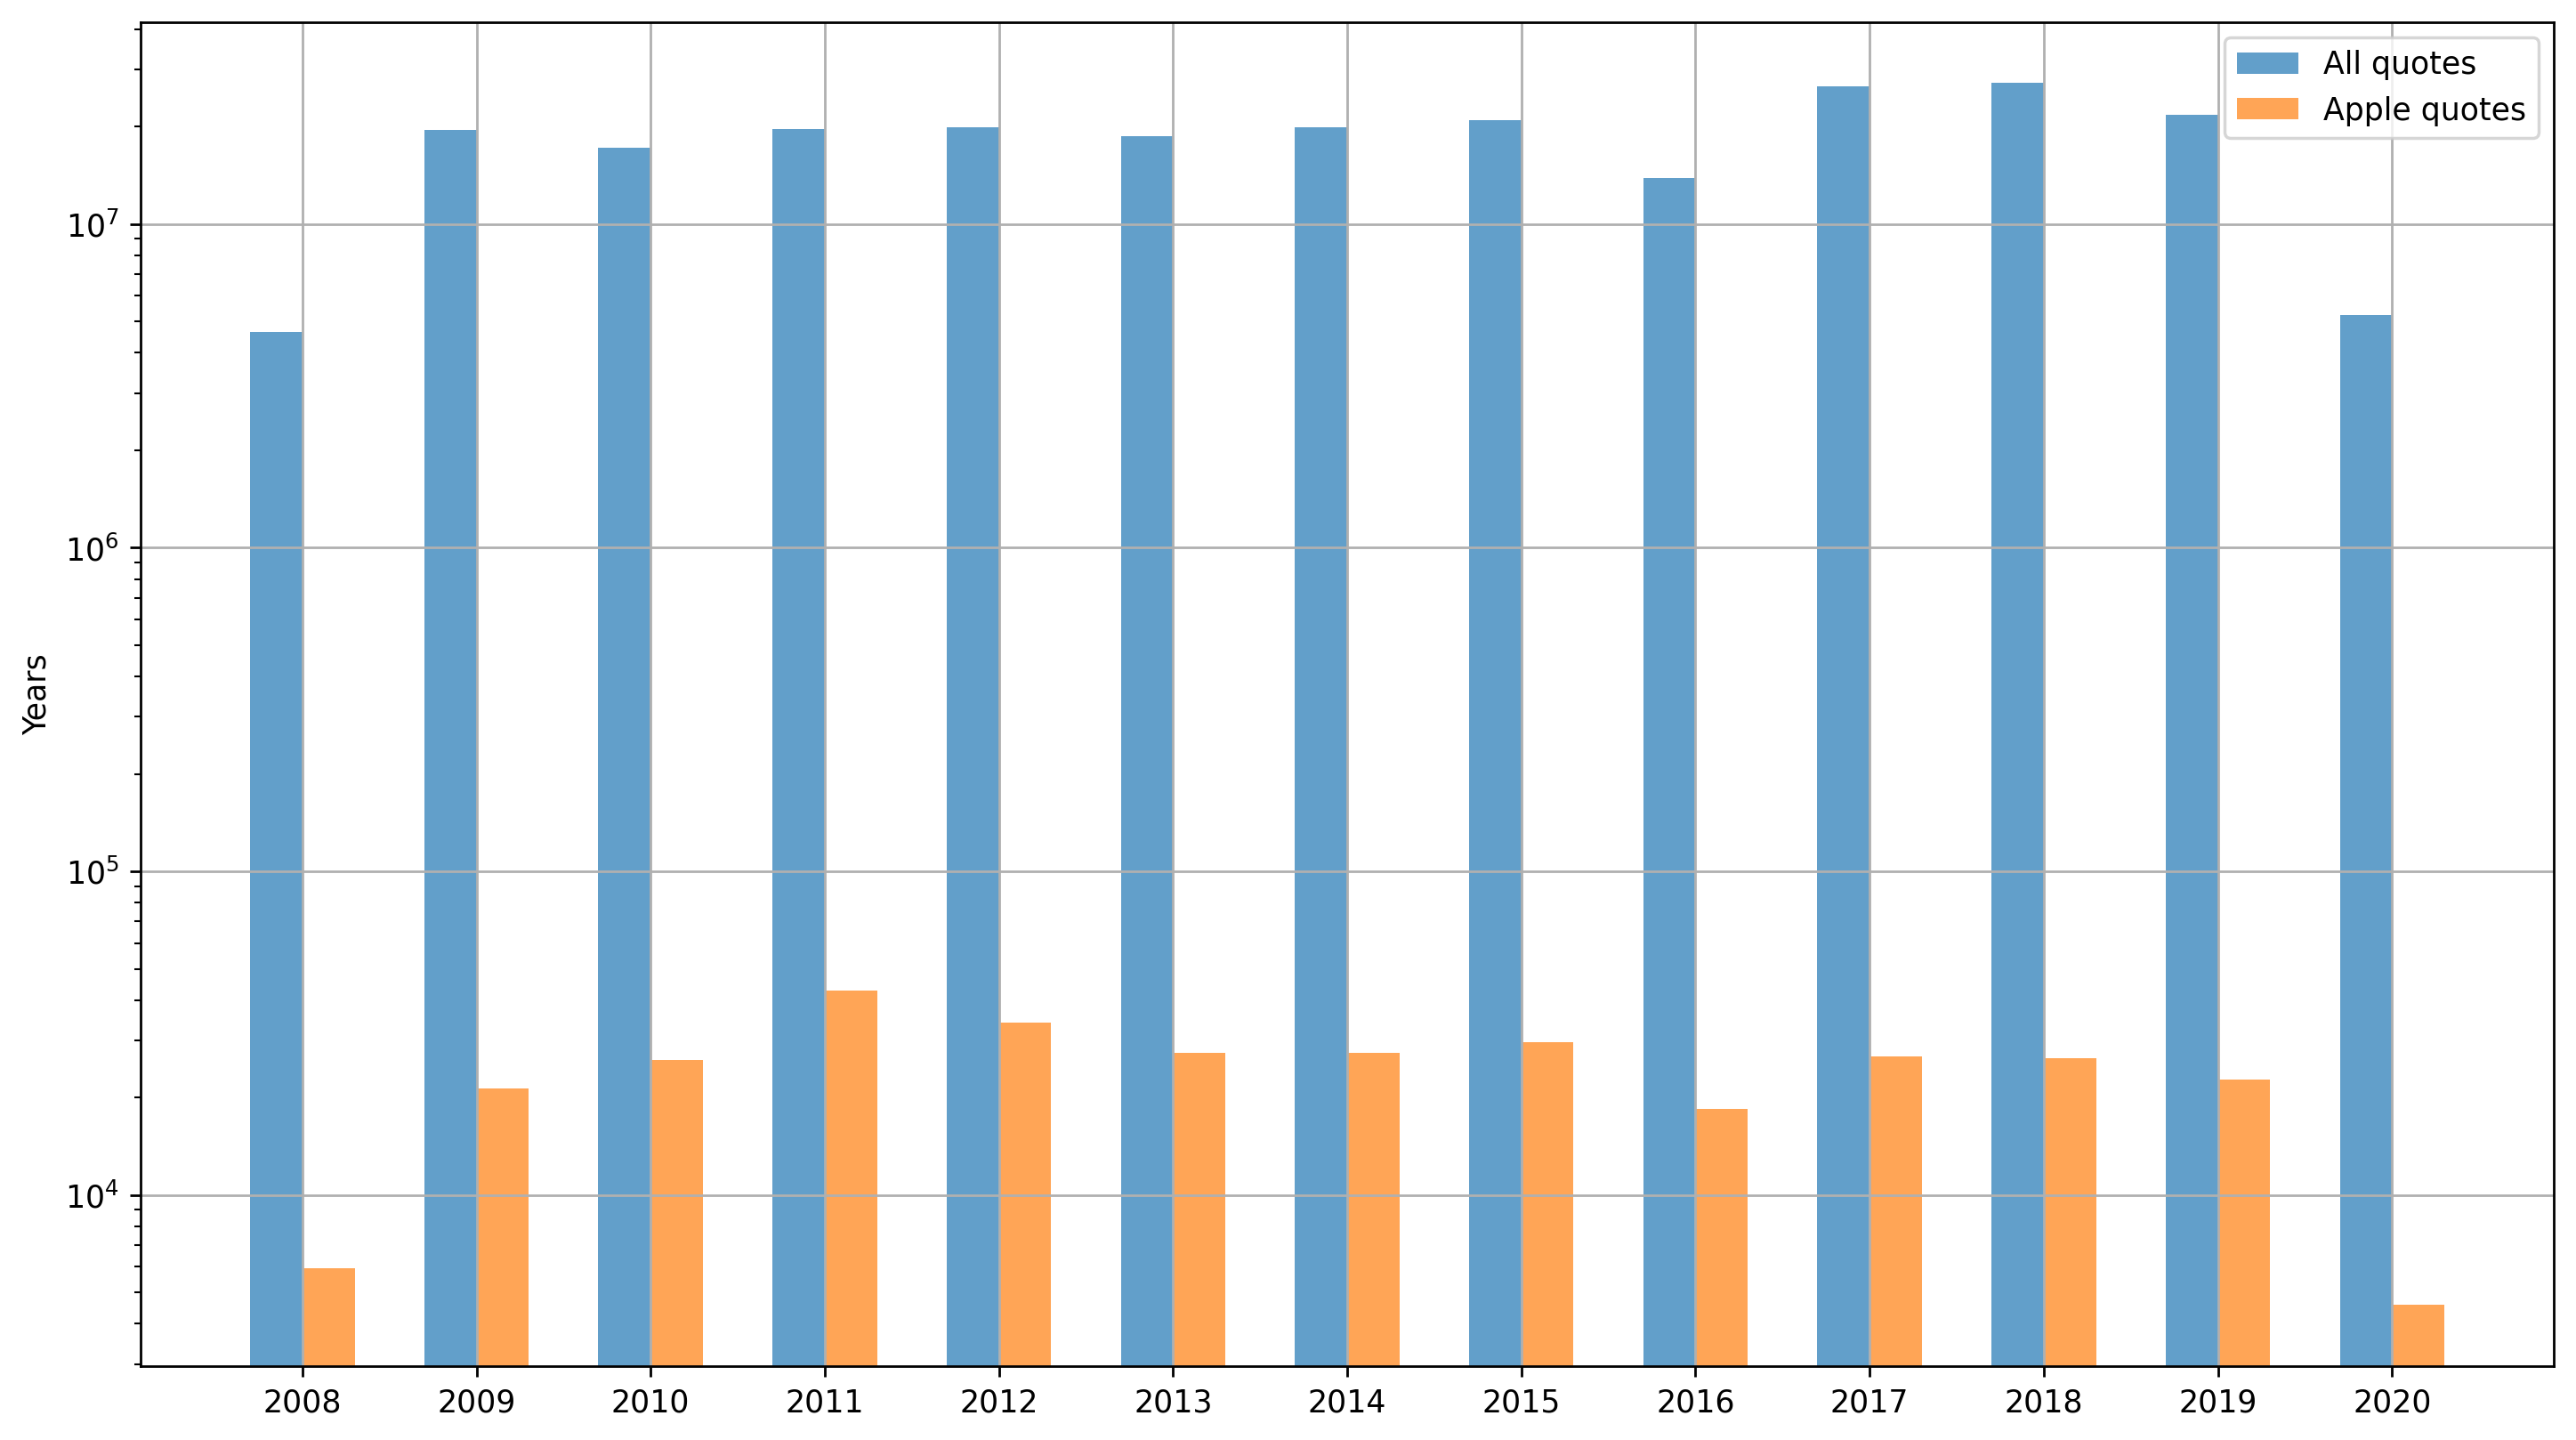

In [35]:
# Plot the results
frequency_all = [4641330, 19567082, 17208434, 19632724, 19849872, 18614447, 19896843, 20874338, 13862129, 26611588, 27228451, 21763302, 5244449]
frequency_apple = [5931, 21306, 26089, 42740, 34162, 27534, 27470, 29631, 18493, 26834, 26460, 22694, 4581]
years = np.arange(2008, 2021)
bar_plots_quotes(frequency_all, frequency_apple, years)

### EDA after filtering

This new filtered dataset provides a great preview of Apple mentions in the media. Let's look more precisely in this dataset :

In [36]:
year = 2019
quote_df = load_quotes(year,category= 'processed quotes')
quotebank_exploration(quote_df)

Let's see what the dataset looks like and what is it's shape.


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2019-01-17-000302,[ O ] ne of the biggest challenges in protecti...,Tim Cook,"[Q1404825, Q265852, Q7803347, Q7803348]",2019-01-17 11:46:57,1,"[[Tim Cook, 0.8848], [None, 0.0949], [Steve Jo...",[https://www.cultofmac.com/601276/tim-cook-tak...,E
1,2019-02-28-002734,A sudden shortfall in iPhone revenue is causin...,None,[],2019-02-28 14:29:32,1,"[[None, 0.581], [Tim Cook, 0.419]]",[http://www.ibtimes.com/apple-layoffs-190-cali...,E
2,2019-09-07-003380,Apple tends to perform well when it changes th...,None,[],2019-09-07 17:19:15,19,"[[None, 0.9333], [Chris Wiltz, 0.0667]]",[http://www.wfmz.com/business/national-and-wor...,E
3,2019-04-02-008471,As Hon Hai shares had lagged behind the broade...,Alex Huang,[Q4717204],2019-04-02 09:36:23,1,"[[Alex Huang, 0.9346], [None, 0.0654]]",[http://www.thestandard.com.hk/breaking-news.p...,E
4,2019-05-03-013085,But we believe that our Mac revenue would have...,Tim Cook,"[Q1404825, Q265852, Q7803347, Q7803348]",2019-05-03 08:09:00,2,"[[Tim Cook, 0.8447], [None, 0.1426], [Luca Mae...",[https://www.laptopmag.com/articles/tim-cook-i...,E


(22694, 9)

We noticed that they were some quotes that were still irrelevant due to the keyword "mac" so we decided to filter again a little our dataset by removing couple of words as "big mac", "freddie mac".

In [37]:
quote_df = refilter(quote_df)

In [38]:
print("Total number of occurences from every quotes of each speaker for year %i" %year)
df_table = plot_table_numOcc(quote_df)
df_table

Total number of occurences from every quotes of each speaker for year 2019


,numOccurrences
speaker,
tim cook,22102
jeff williams,1937
craig federighi,1604
steve jobs,1565
phil schiller,1442
president donald trump,1255
james bell,1060
luca maestri,699
eddy cue,556


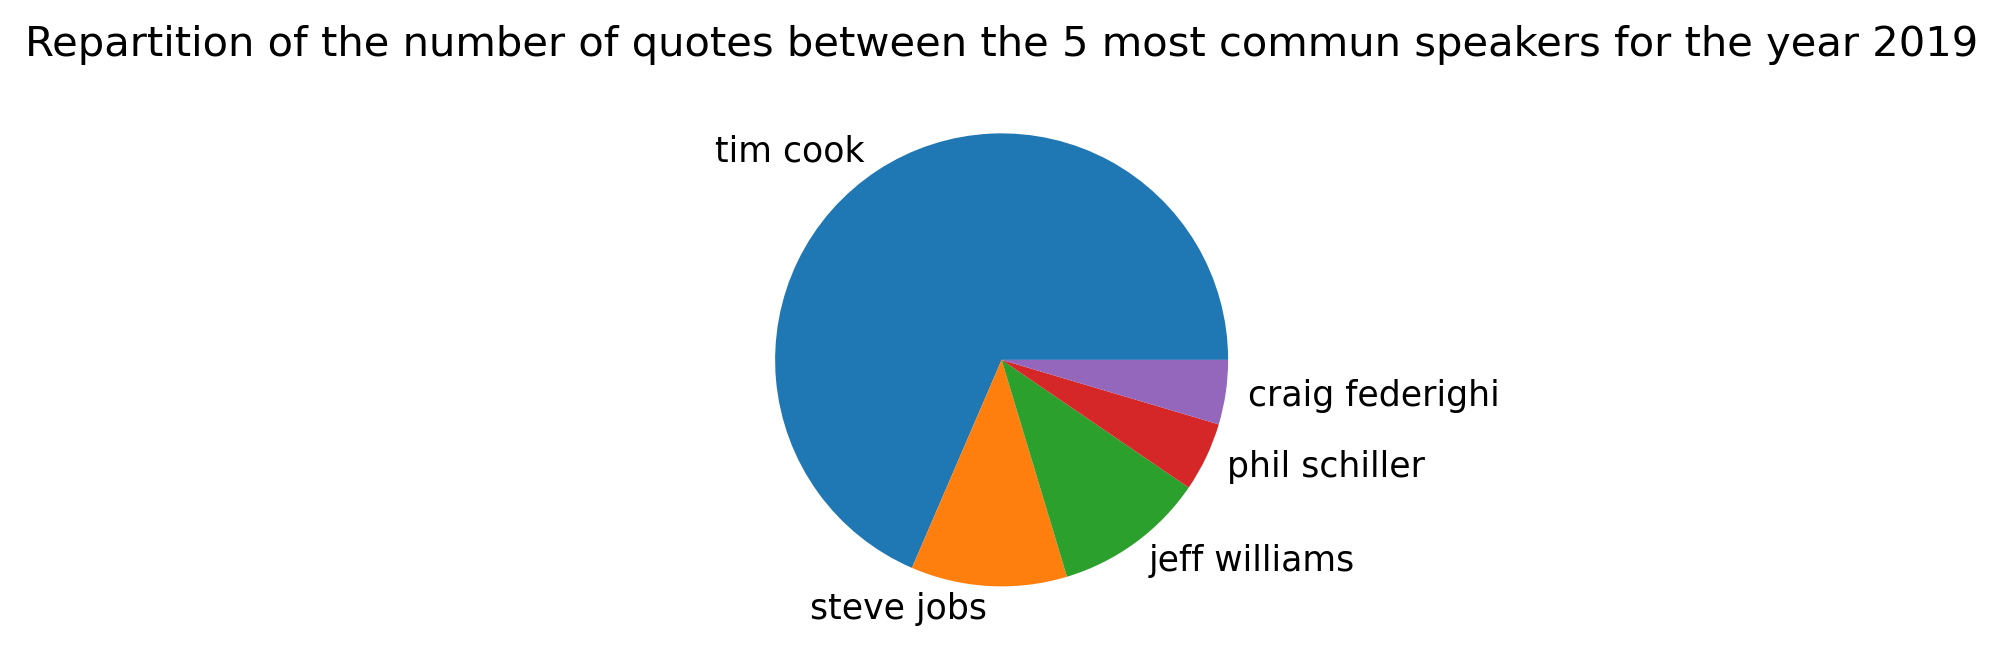

In [39]:
plot_pie_numquote(quote_df, year, head_ = 5)

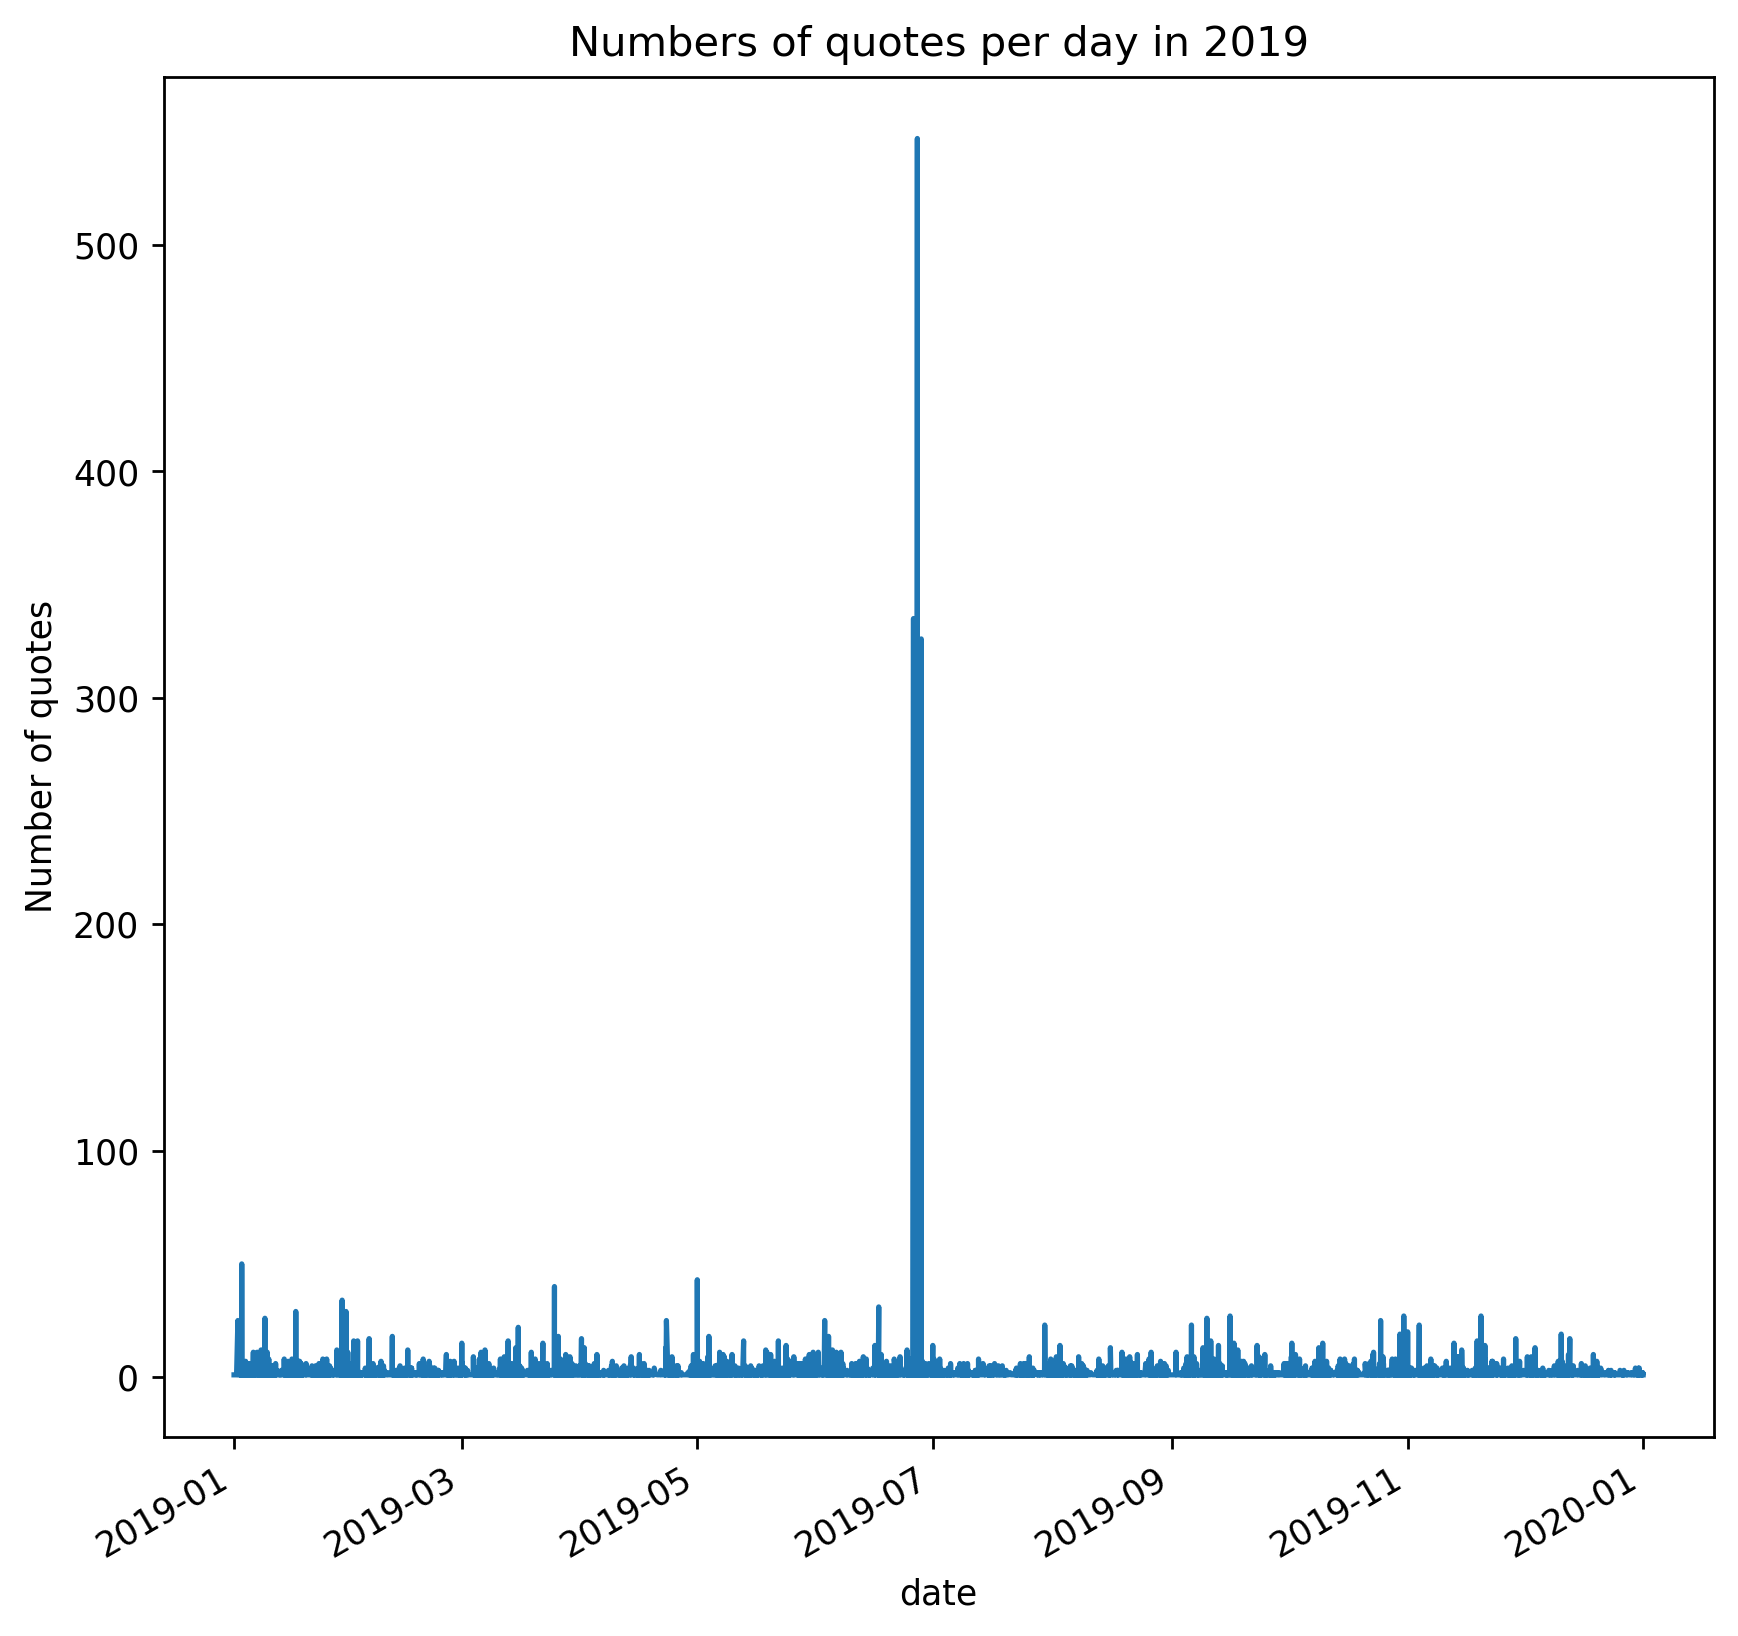

In [40]:
plot_quotes_per_day(quote_df, year)

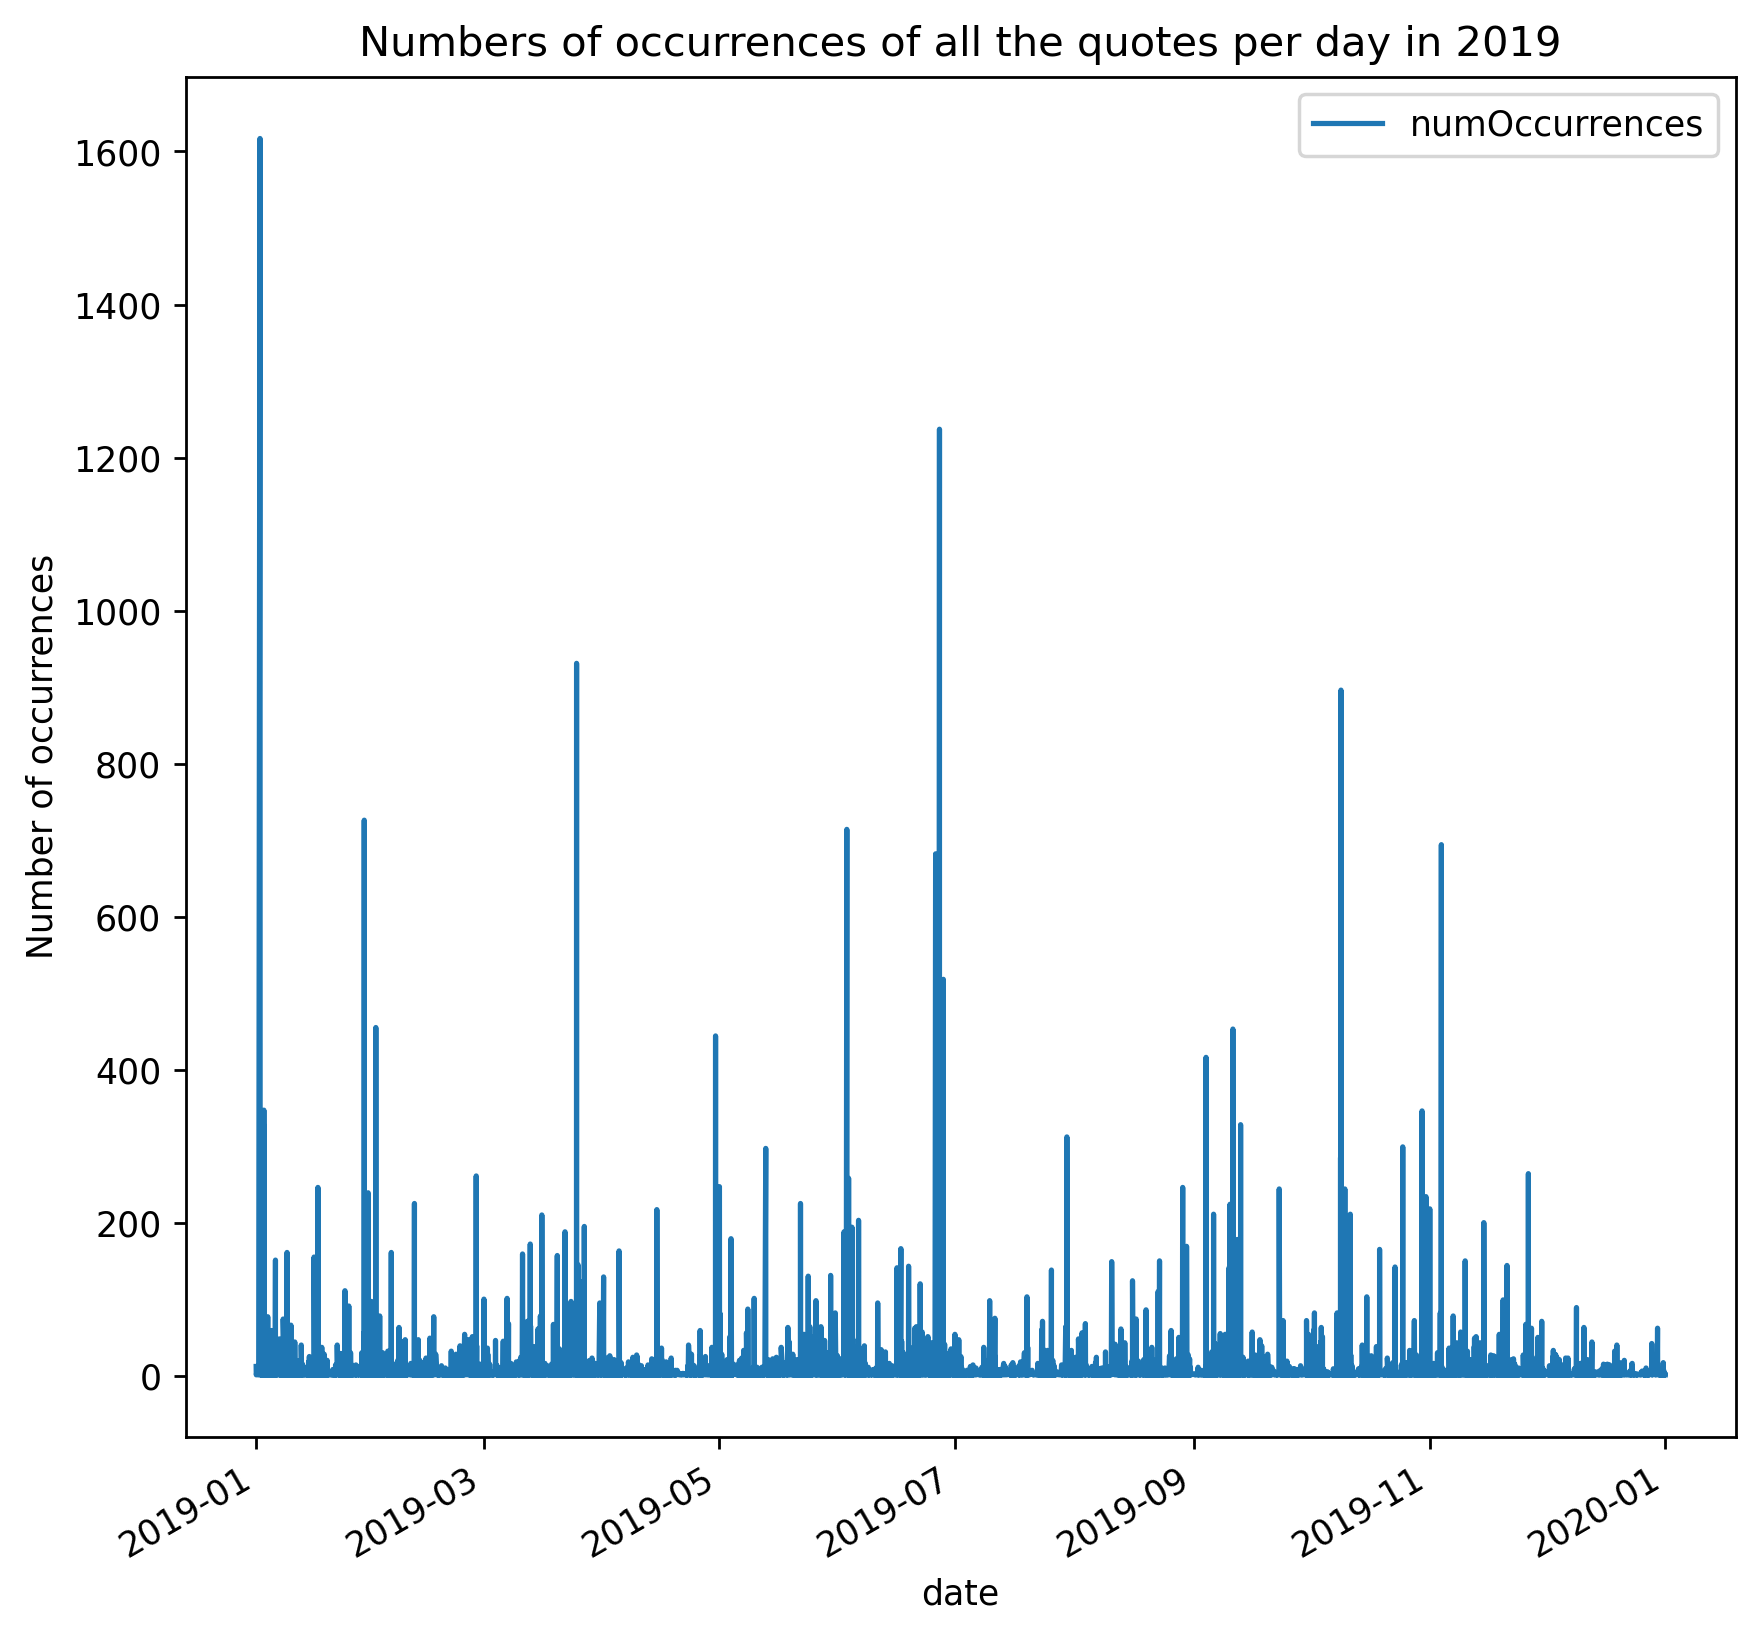

In [41]:
plot_numOcc_per_day(quote_df, year)

***

# Wikipedia

For now, we have our data set with some quotes more or less connected to Apple and the speaker corresponding to each quote. Now, we want to know what is the "impact" of the speaker. We want to know how much this person is famous or/and has an impact on the others. For that, we will use Wikipedia that has almost a page for every famous person. So the idea now is to get the data set coming from the Wikipedia API, study it and see how we can use it for our problem.

For now, we will use the `.parquet` already given from the Wikipedia API and we will see later if we need more information than the already given ones. The first idea will be to group together all `.parquet` files in one single dataframe.

In [ ]:
# Get all the parquet files in a single dataframe
df_wiki = concat_wiki_files()
display(df_wiki.head(10))

This being done, we can see multiple features for each speaker. An interesting one for us is the `id` that will corresponds to the `qids` of the QuoteBank data set. The idea will be to keep only the speakers in the Wikipedia dataframe that are in our filtered quotes data set. Then, we will get all the speakers' ID that have spoken in our filtered quotes data set.

In [ ]:
''' !!! MAYBE CHANGE THE PLACE OF THIS CELL !!! '''
# Here we group together all the filtered quotes in a single dataframe
df_filtered = get_filtered_quotes()
display(df_filtered.head(10))

In [ ]:
# Now we keep only the 'qids' and we remove duplicates
quotes_ID = get_wiki_ids(df_filtered)

In [ ]:
pd.DataFrame(quotes_ID)

Now, we have to find a way to get a correspondance between the `qids` of the quotes and the `id` of the Wikipedia data set. This will informs us if there is some speaker that are not in our Wikipedia data set, and then if we must find another way to obtain the informations we want.

[in progress...]

After that, we want to get all the snumber of views on the Wikipedia pages of the different speakers

***

# Yahoo Finance Data Exploration

The yfinance library provides financial metrics on most stocks and indices. It will allow us to quantitatively compare the stock price and volume of Apple to a major equity index, such that the S&P500. Later on we will use this new dataset to find and compare days of high volatility, and find any correlation with potential speakers and quotations.

A stock dataframe consists of the following features: 
 * `Date`: Primary key of the quotation (format: "YYYY-MM-DD").
 * `Open`: Stock price at the daily opening of the market.
 * `High`: Highest stock price reached during the day.
 * `Low`: Lowest stock price reached during the day.
 * `Adj Close`:  Adjusted stock price at the daily close of the market.
 * `Volume`: Amount of stocks that changed hands during the day.

 We will focus our study on the `Adjusted Open`, `Adjusted Close` and `Volume`.

## A first preview of the performance of $AAPL
As stated previously we will focus on the Apple stock performance, using the daily opening, daily close and volume metrics from the yfinance API. We load the stock metrics for the year 2019 and perform some first observation on this data.

In [ ]:
apple_ticker = "AAPL"
spy_ticker = "SPY"
year = 2019
apple_stock = yf.download(apple_ticker, start=f'{year}-01-01', end=f'{year}-12-31', progress = False)
apple_stock.head()

### Price and Volume
As stated previously, we can first look at the performance of the $AAPL stock in term of its stock price and daily volume. Empirically we observe that the days of sharp decreases or increase are often linked to day of high volume volatility. Later on we may look at the QuoteBank dataset if the days of high volatility also see many Apple related quotes.

In [ ]:
stock("AAPL", year = year, fig = "price_volume")

We can also observe with histograms the distribution of the daily volume of exchange of the Apple stock. From our observations it may be fitted appropriately as a left skewed distribution, and the average daily volume sits around 112 millions stocks trade daily. Later on we will focus on the days of high volatility, i.e with higher volume than usual.

In [ ]:
stock("AAPL", year = year, fig = "daily_diff")

### Daily price difference
We pursue this idea of studying the volatility as an indicator of meaningful trading days, by introducing the daily price indicator. By taking the difference between the daily closing and opening price, and dividing by the opening price, we obtain the percentage of increase or decrease of the stock during that day. We observe a gaussian-like distribution of the daily percentage change of the stock price, with a mean slightly above 0 at 0.1799%. We will later on compare this histogram of the daily price change with other major stocks and we will look more closely at the high change days.

In [ ]:
stock("AAPL", year = year, fig = "volume")

### Comparison with the overall market
The S&P 500 is regarded as one of the best gauge of large-cap U.S. equities. It is a weighted average of some of the 500 best and largest american companies, 6.2% of which is the Apple stock. It is often taken as a general indicator of the overall health of the US stock market, and individual stock may be compared to the S&P. In the following figure, we observe than during the 2019 trading period, the Apple stock generally underperformed the S&P but still ended up relatively with the same performance. Both are highly correlated.

In [ ]:
compare(spy_ticker, apple_ticker, year = year, fig = "price")

Looking at the volume of exchange of both SPY and AAPL, we observe again a strong correlation between the two. One of the reasons is that the day of high volume exchange are often close or during the week of the quarterly results. Most companies in the S&P 500 provide their quarterly results in the same time-frame.

In [ ]:
compare(spy_ticker, apple_ticker, year = year, fig = "volume")

Finally we can again take a closer look at the distribution of the daily price difference. Interestingly enough we observe that both stocks performs *in average* with a mean daily difference close to 0 with an normal distribution. However the Apple stock has a greater variance than the S&P, in other words the Apple stock is more suggest to volatility than the S&P. In a financial context, this is seen as being a riskier security with the same yielding. 

In [ ]:
compare(spy_ticker, apple_ticker, year = year, fig = "daily_diff")

***
### Subtask 1 : 
What is the role of the media coverage in explaining stock market fluctuations ? How does the media coverage of Apple evolve over time ? Are there any specific patterns we can observe across the years, for instance bigger coverage when there is the keynote ? Thousands of events occur around the world every day, and humans notice a small subset of these events. Yet, the media attract attention to specific events. In this regard, a company’s media visibility will definitely affect its stock price. We investigate the reciprocal relationships between the fluctuations of the stock market of Apple and media coverage related to this company for a period of 12 years (2008–2020). 

***
### Subtask 2 
Who are the individuals who have influence over potential customers, and do these influencers have an impact on the Apple company image and eventually, on the stock market ? Personality  plays  a huge  role  in  consumer  buying  behavior. Indeed, the high level of public attention and the positive emotional responses that define celebrity increase the economic opportunities available to a firm. We hypothesize that quotes from celebrities significantly impact the stock market, whereas quotes from ordinary people have no significant predictive power. One defining characteristic of a celebrity is that it is a social actor who attracts large-scale public attention : the greater the number of people who know of and pay attention to the actor, the greater the extent and value of that celebrity.

***

### Subtask 3 :
What is the influence of the public opinions or emotions about Apple expressed in the media on the stock market ? Media influences beliefs by providing compelling information about events. In this regard, the media have been identified to play a significant role in shaping the consensus market opinion. Can a series of news articles make a stock rise? On the other hand, can it send a market into turmoil ? We hypothesize that emotions of the public in the media about a company would reflect in its stock price. Indeed, positive news about Apple would encourage people to invest in the stocks of the company. On the other hand, increases in expressions of anxiety, worry and fear would predict downward pressure on the stocks of the company. Understanding the author's opinion from a piece of text is the objective of sentiment analysis. We classify quotes as positive, negative and neutral based on the sentiment present. We want to answer the following questions : are the stock price drops/rises correlated with negative/positive quotes ? 